<h1 align=center><font size = 10>ASM 1</font></h1>

# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file [College.csv](https://drive.google.com/file/d/167ysw5-Bf15_Gm_aiePZfrS3fBWWfJVl/view) trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# plt.style.use("ggplot")
%matplotlib inline

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [2]:
def drawLine(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
    # và hiển thị hệ số R2
    y_pred = model.predict(X_test)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_test, y_test, c="g", marker="o")
    ax.plot(X_test, y_pred, color="orange", linewidth=1, alpha=0.7)
    ax.set_xlabel(title)
    ax.set_ylabel("Accept")

    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

In [3]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_zlabel("prediction")

    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:, 0]
    col2 = X_test[:, 1]

    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max - x_min) / 10)
    y = np.arange(y_min, y_max, (y_max - y_min) / 10)
    x, y = np.meshgrid(x, y)

    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c="g", marker="o")
    ax.plot_wireframe(x, y, z, color="orange", alpha=0.7)

    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [4]:
# Nhập code của bạn ở đây
df = pd.read_csv(filepath_or_buffer="./College.csv", sep=",", index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [5]:
# Convert Private columns into Yes or No
df["Private"] = df["Private"].map({"Yes": 1, "No": 0}, na_action="ignore")
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [6]:
# calculate correlation matrix for college (df)
df_corr = df.corr(method="pearson")
df_corr

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Private,1.000000,-0.432095,-0.475252,-0.567908,0.164132,0.095752,-0.615561,-0.452088,0.552650,0.340532,-0.018549,-0.304485,-0.156714,-0.129620,-0.472205,0.414775,0.258461,0.336162
Apps,-0.432095,1.000000,0.943451,0.846822,0.338834,0.351640,0.814491,0.398264,0.050159,0.164939,0.132559,0.178731,0.390697,0.369491,0.095633,-0.090226,0.259592,0.146755
Accept,-0.475252,0.943451,1.000000,0.911637,0.192447,0.247476,0.874223,0.441271,-0.025755,0.090899,0.113525,0.200989,0.355758,0.337583,0.176229,-0.159990,0.124717,0.067313
Enroll,-0.567908,0.846822,0.911637,1.000000,0.181294,0.226745,0.964640,0.513069,-0.155477,-0.040232,0.112711,0.280929,0.331469,0.308274,0.237271,-0.180794,0.064169,-0.022341
Top10perc,0.164132,0.338834,0.192447,0.181294,1.000000,0.891995,0.141289,-0.105356,0.562331,0.371480,0.118858,-0.093316,0.531828,0.491135,-0.384875,0.455485,0.660913,0.494989
Top25perc,0.095752,0.351640,0.247476,0.226745,0.891995,1.000000,0.199445,-0.053577,0.489394,0.331490,0.115527,-0.080810,0.545862,0.524749,-0.294629,0.417864,0.527447,0.477281
F.Undergrad,-0.615561,0.814491,0.874223,0.964640,0.141289,0.199445,1.000000,0.570512,-0.215742,-0.068890,0.115550,0.317200,0.318337,0.300019,0.279703,-0.229462,0.018652,-0.078773
P.Undergrad,-0.452088,0.398264,0.441271,0.513069,-0.105356,-0.053577,0.570512,1.000000,-0.253512,-0.061326,0.081200,0.319882,0.149114,0.141904,0.232531,-0.280792,-0.083568,-0.257001
Outstate,0.552650,0.050159,-0.025755,-0.155477,0.562331,0.489394,-0.215742,-0.253512,1.000000,0.654256,0.038855,-0.299087,0.382982,0.407983,-0.554821,0.566262,0.672779,0.571290
Room.Board,0.340532,0.164939,0.090899,-0.040232,0.371480,0.331490,-0.068890,-0.061326,0.654256,1.000000,0.127963,-0.199428,0.329202,0.374540,-0.362628,0.272363,0.501739,0.424942


Trực quan ma trận trực quan bằng Seaborn

<Axes: >

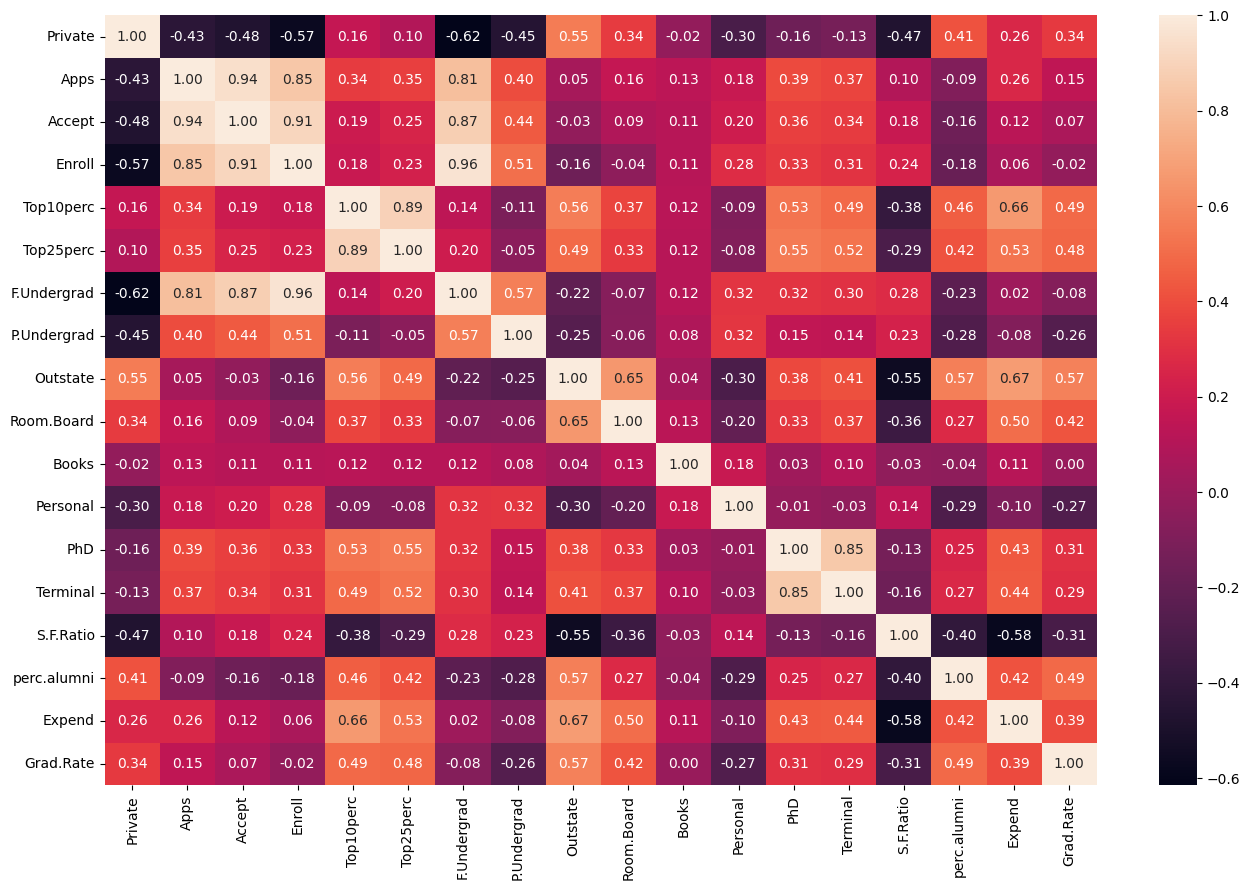

In [7]:
# Nhập code của bạn ở đây
plt.figure(figsize=(16, 10))
sns.heatmap(data=df_corr, annot=True, fmt=".2f")

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [8]:
feature_df = df.drop(columns="Accept")
result_df = df["Accept"]

Trực quan từng đặc trưng với mục tiêu

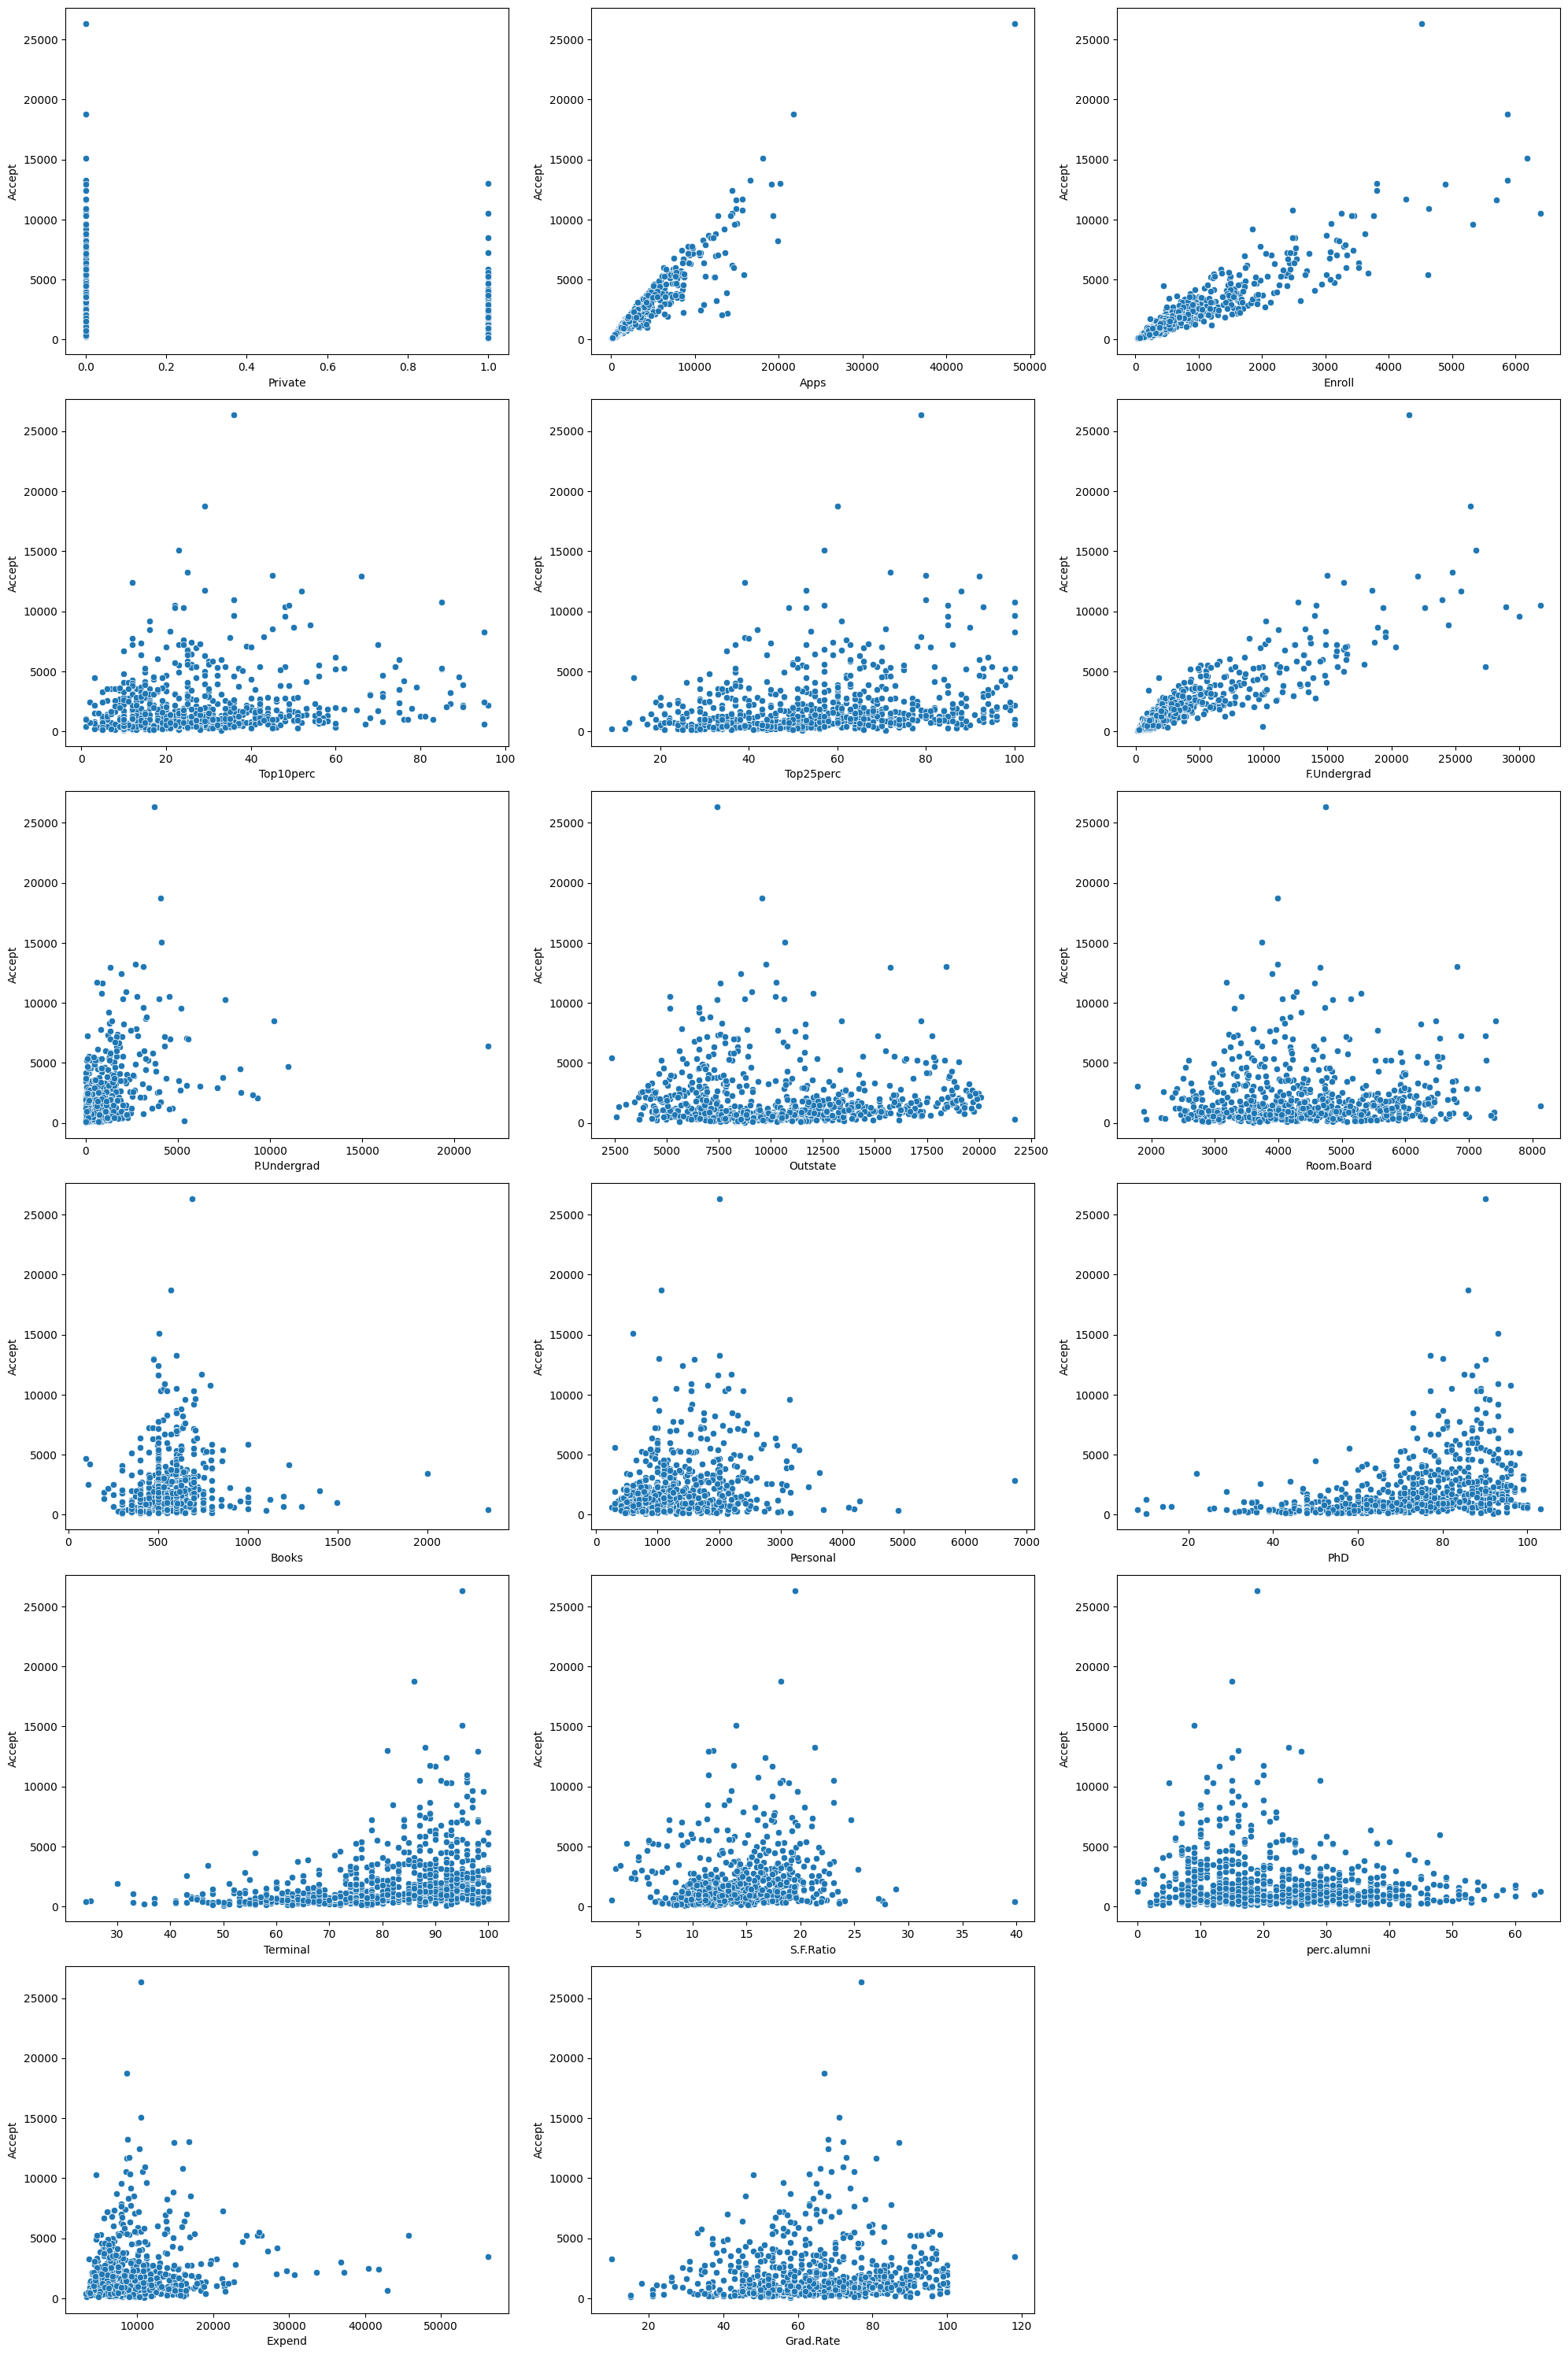

In [9]:
plt.figure(figsize=(20, 30))

for i, col in enumerate(feature_df.columns.to_list()):
    # 17 plot so it must be 4x4 + 1 => (4,5,x)
    plt.subplot(6, 3, i + 1)
    sns.scatterplot(x=feature_df[col], y=result_df)


plt.tight_layout(pad=1.0)

plt.show()

Look at this graph, we can see some relationship 
<!-- NOTE: Later -->

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [10]:
# Nhập code của bạn ở đây
X = feature_df
y = result_df

In [11]:
X.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
y.head()

Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [13]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7
)

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [14]:
# Nhập code của bạn ở đây
X_train_rb = np.asanyarray(X_train["Room.Board"])
X_test_rb = np.asanyarray(X_test["Room.Board"])
y_train_rb = np.asanyarray(y_train)
y_test_rb = np.asanyarray(y_test)

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [15]:
# Điều chỉnh shape bằng reshape
X_train_rb = np.reshape(a=X_train_rb, newshape=(-1, 1))
y_train_rb = np.reshape(a=y_train_rb, newshape=(-1, 1))

X_test_rb = np.reshape(a=X_test_rb, newshape=(-1, 1))
y_test_rb = np.reshape(a=y_test_rb, newshape=(-1, 1))

Xây dựng và huấn luyện mô hình

In [16]:
model_single_regr = LinearRegression()
model_single_regr.fit(X=X_train_rb, y=y_train_rb)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [17]:
# Nhập code của bạn ở đây
model_single_regr.score(X=X_test_rb, y=y_test_rb)

-0.0026669864145500988

Trực quan mô hình hóa với dữ liệu test

In [18]:
X_train_rb.reshape(-1).max()

8124

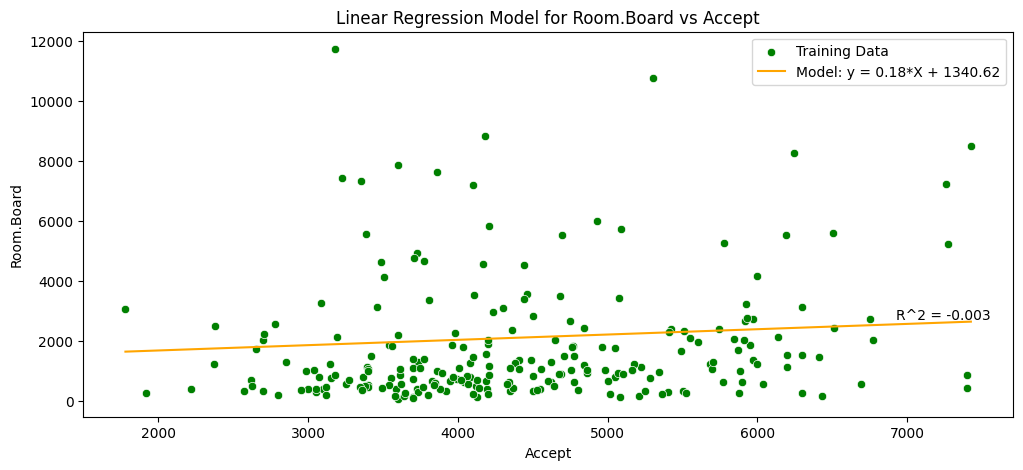

In [19]:
def linear_regression_visualize(model, X_test_, y_test_, name):
    y_pred = model.predict(X=X_test_)

    plt.figure(figsize=(12, 5))

    sns.scatterplot(
        x=np.reshape(a=X_test_, newshape=(-1)),
        y=np.reshape(a=y_test_, newshape=(-1)),
        color="green",
        label="Training Data",
    )
    sns.lineplot(
        x=np.reshape(a=X_test_, newshape=(-1)),
        y=np.reshape(a=y_pred, newshape=(-1)),
        color="orange",
        label="Model: y = {:.2f}*X + {:.2f}".format(
            model.coef_[-1][-1], model.intercept_[-1]
        ),
    )

    plt.annotate(
        "R^2 = {:.3f}".format(model.score(X=X_test_, y=y_test_)),
        xy=(X_test_.reshape(-1).max(), y_pred.reshape(-1)[-1]),
        textcoords="offset points",
        xytext=(-20, 20),
        ha="center",
    )

    plt.title("Linear Regression Model for {} vs Accept".format(name))
    plt.xlabel("Accept")
    plt.ylabel(name)

    plt.legend()

    plt.show()


linear_regression_visualize(
    model=model_single_regr,
    X_test_=X_test_rb,
    y_test_=y_test_rb,
    name="Room.Board",
)

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [20]:
# Train test split=
# X_train_enr, X_test_enr, y_train_enr, y_test_enr = train_test_split(
#     feature_df["Enroll"], test_size=0.3, random_state...
# )
X_train_enr = np.asanyarray(X_train["Enroll"])
y_train_enr = np.asanyarray(y_train)
X_test_enr = np.asanyarray(X_test["Enroll"])
y_test_enr = np.asanyarray(y_test)

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [21]:
# Update variable by exec
cache = ["X_train_enr", "y_train_enr", "X_test_enr", "y_test_enr"]

for var_name in cache:
    exec("{} = np.reshape(a={}, newshape=(-1, 1))".format(var_name, var_name))

del cache

X_train_enr.shape

(543, 1)

Xây dựng và huấn luyện mô hình

In [22]:
model_single_regr_enr = LinearRegression()
model_single_regr_enr.fit(X=X_train_enr, y=y_train_enr)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [23]:
model_single_regr_enr.score(X=X_test_enr, y=y_test_enr)

0.8578204867356156

Trực quan mô hình với dữ liệu test

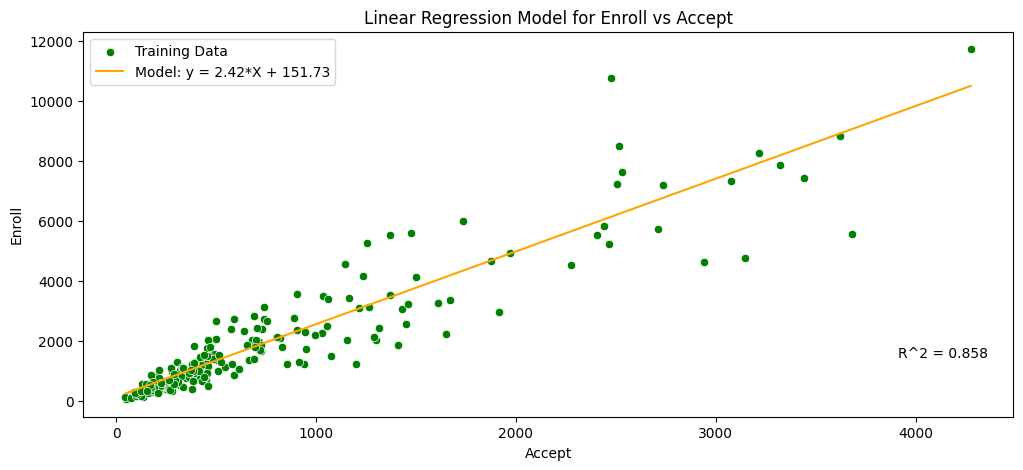

In [24]:
linear_regression_visualize(
    model=model_single_regr_enr,
    X_test_=X_test_enr,
    y_test_=y_test_enr,
    name="Enroll",
)

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

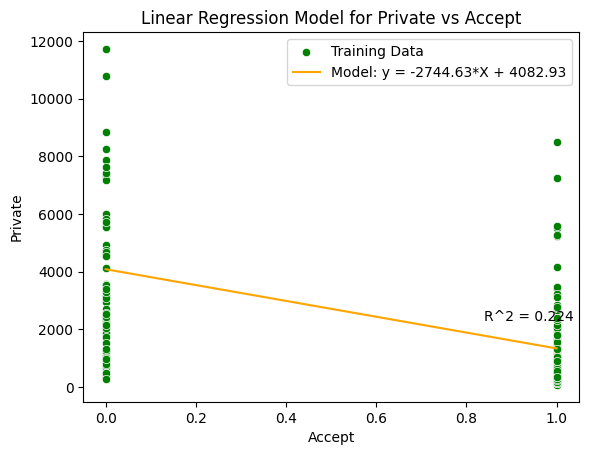

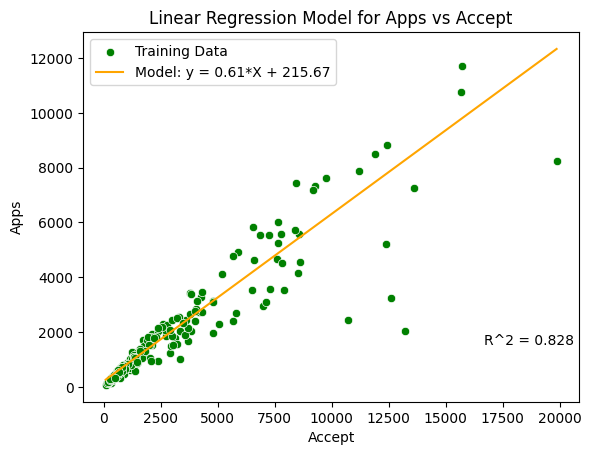

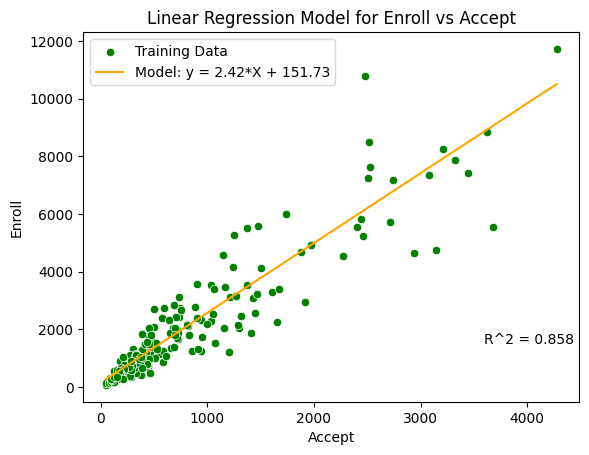

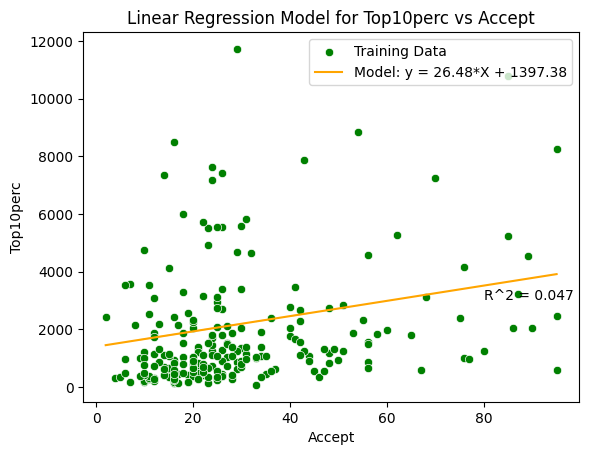

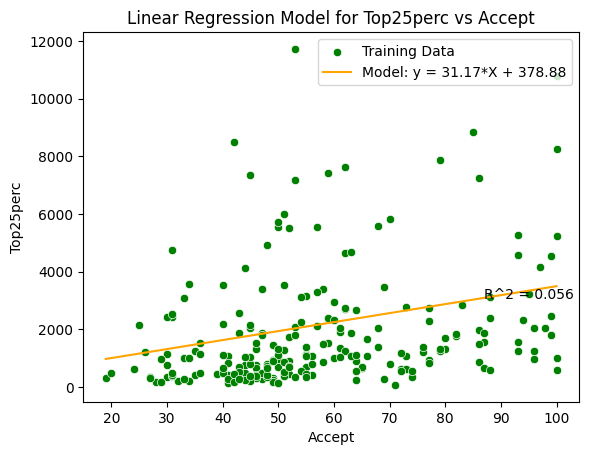

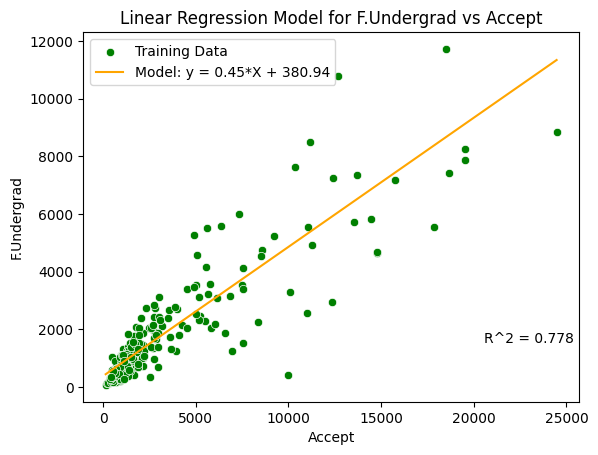

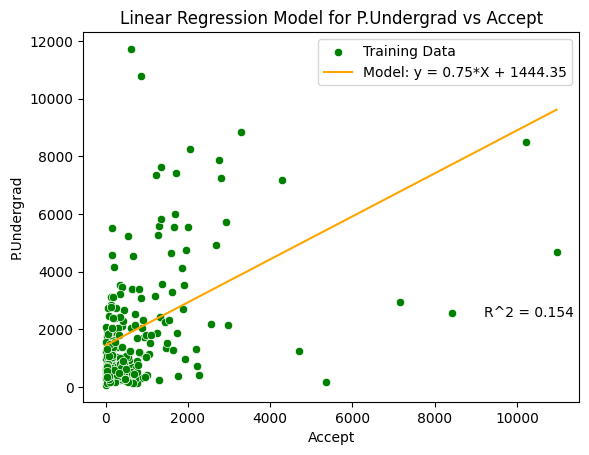

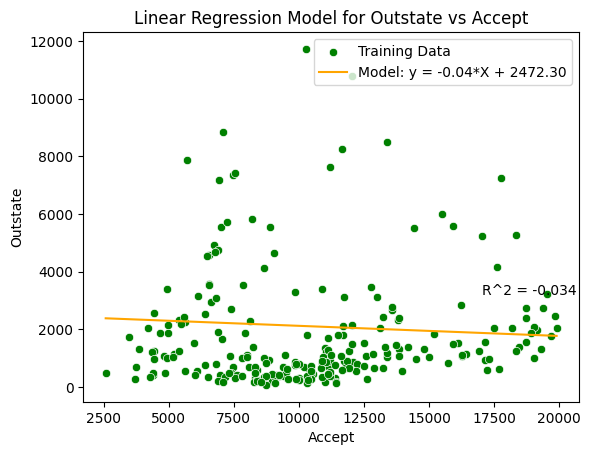

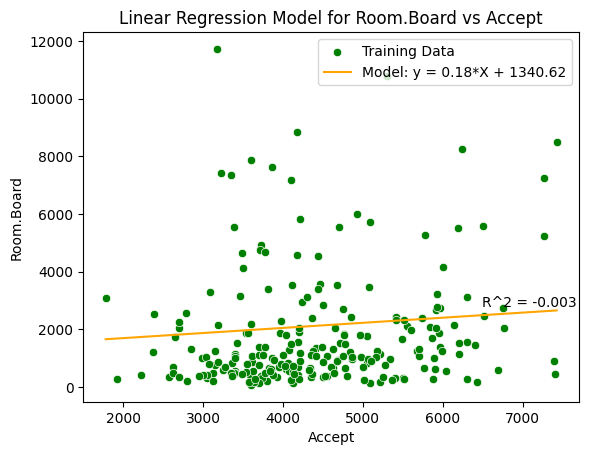

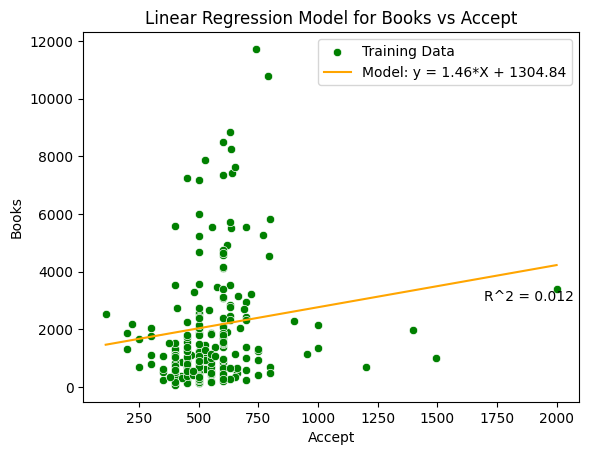

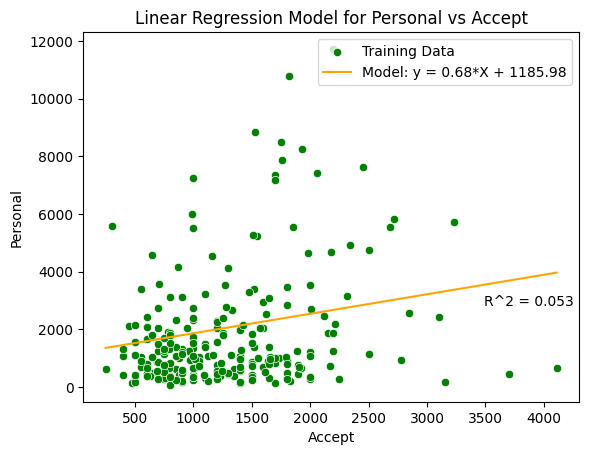

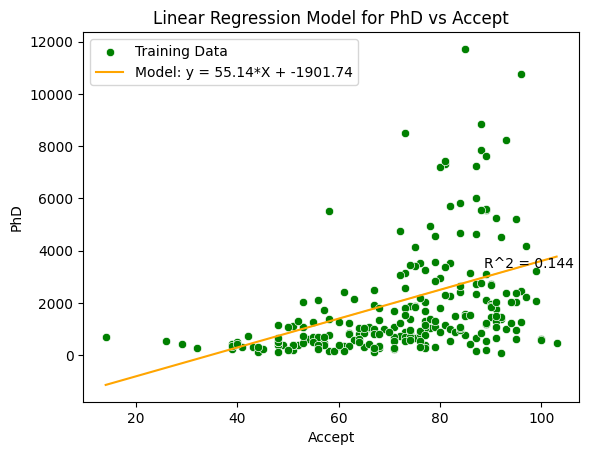

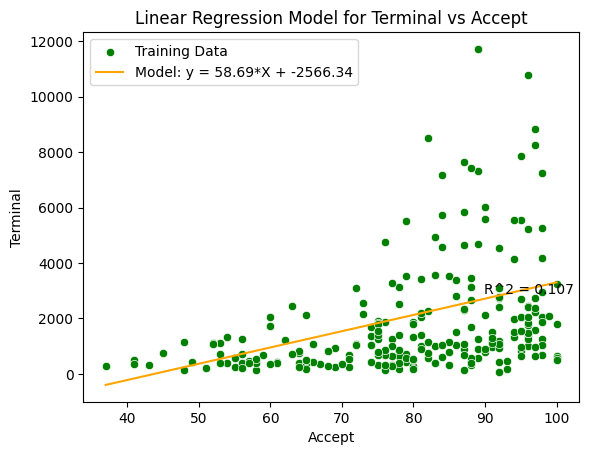

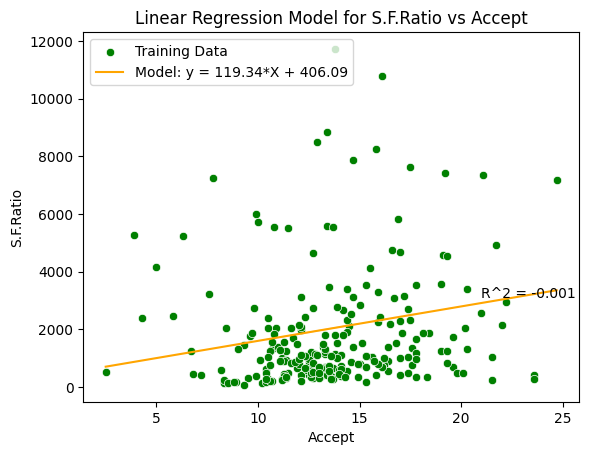

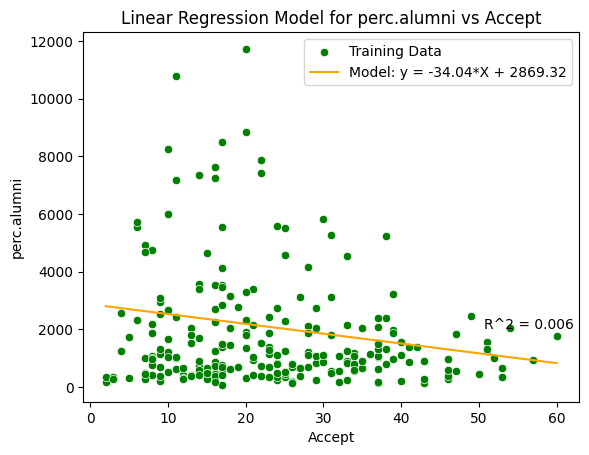

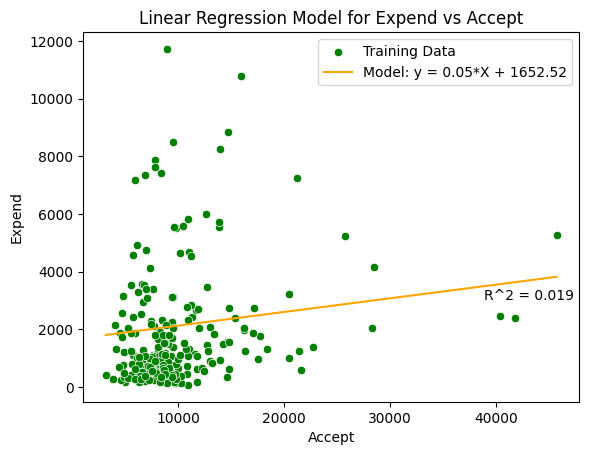

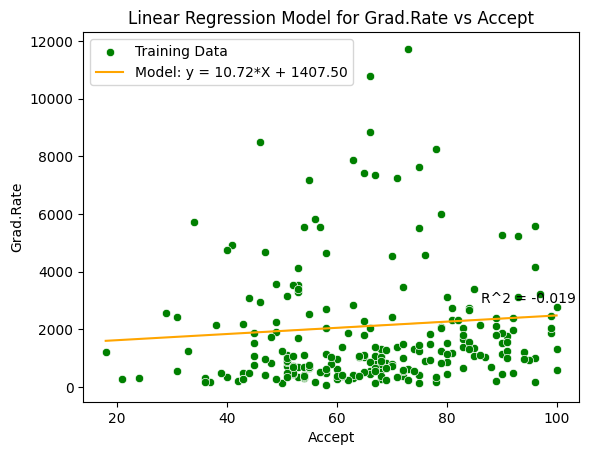

In [25]:
# in order to use loop in this problem, let's define our
# simple_linear_regression function
def simple_linear_regression(X_train, y_train, X_test, y_test):
    # Convert array from 1D to 2D with shape of (m,1)
    # NOTE:Update variable by exec cannot be done inside function
    X_train = np.reshape(a=X_train, newshape=(-1, 1))
    y_train = np.reshape(a=y_train, newshape=(-1, 1))
    X_test = np.reshape(a=X_test, newshape=(-1, 1))
    y_test = np.reshape(a=y_test, newshape=(-1, 1))

    model_single_regr = LinearRegression()
    model_single_regr.fit(X=X_train, y=y_train)

    score_ = model_single_regr.score(X=X_test, y=y_test)
    coef_ = model_single_regr.coef_
    intercept_ = model_single_regr.intercept_
    y_pred = model_single_regr.predict(X=X_test)

    return score_, coef_, intercept_, y_pred


def all_features_regr():
    plot_count = len(X_train.columns.to_list())
    plot_count_col = 2
    plot_count_row, rem = divmod(plot_count, plot_count_col)
    if rem != 0:
        plot_count_row += 1
    # return plot_count_row, rem
    for i, feature in enumerate(X_train.columns.to_list()):
        # Taking feature from train/test data
        X_train_ = np.asanyarray(X_train[feature])
        y_train_ = np.asanyarray(y_train)
        X_test_ = np.asanyarray(X_test[feature])
        y_test_ = np.asanyarray(y_test)

        score_, coef_, intercept_, y_pred_ = simple_linear_regression(
            X_train_, y_train_, X_test_, y_test_
        )

        # Subplot
        # plt.figure(figsize=(30, 10))
        # plt.subplot(plot_count_row, plot_count_col, i + 1)
        sns.scatterplot(
            x=np.reshape(a=X_test_, newshape=(-1)),
            y=np.reshape(a=y_test_, newshape=(-1)),
            color="green",
            label="Training Data",
        )
        sns.lineplot(
            x=np.reshape(a=X_test_, newshape=(-1)),
            y=np.reshape(a=y_pred_, newshape=(-1)),
            color="orange",
            label="Model: y = {:.2f}*X + {:.2f}".format(
                coef_[-1][-1], intercept_[-1]
            ),
        )

        plt.annotate(
            "R^2 = {:.3f}".format(score_),
            xy=(X_test_.reshape(-1).max(), y_pred_.reshape(-1)[-1]),
            textcoords="offset points",
            xytext=(-20, 20),
            ha="center",
        )

        plt.title("Linear Regression Model for {} vs Accept".format(feature))
        plt.xlabel("Accept")
        plt.ylabel(feature)

        plt.legend()

        plt.show()


all_features_regr()

# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [26]:
X_train_enr_rb = np.asanyarray(X_train[["Enroll", "Room.Board"]])
y_train_enr_rb = np.asanyarray(y_train)
X_test_enr_rb = np.asanyarray(X_test[["Enroll", "Room.Board"]])
y_test_enr_rb = np.asanyarray(y_test)

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [27]:
X_train_enr_rb = np.reshape(a=X_train_enr_rb, newshape=(-1, 2))
y_train_enr_rb = np.reshape(a=y_train_enr_rb, newshape=(-1, 1))
X_test_enr_rb = np.reshape(a=X_test_enr_rb, newshape=(-1, 2))
y_test_enr_rb = np.reshape(a=y_test_enr_rb, newshape=(-1, 1))

Xây dựng và huấn luyện mô hình

In [28]:
model_multiple_regr_enr_rb = LinearRegression()
model_multiple_regr_enr_rb.fit(X=X_train_enr_rb, y=y_train_enr_rb)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [29]:
model_multiple_regr_enr_rb.score(X=X_test_enr_rb, y=y_test_enr_rb)

0.8764371774214047

Trực quan mô hình với dữ liệu test

In [30]:
y_pred_enr_rb = model_multiple_regr_enr_rb.predict(X=X_test_enr_rb)
# np.reshape(a=y_pred_enr_rb,newshape=(-1, 0))
drawPlane(
    model_multiple_regr_enr_rb, X_test_enr_rb, y_pred_enr_rb, title="Test"
)
plt.show()

R2: 1.0
Intercept(s):  [-1176.62848249]


<Figure size 640x480 with 0 Axes>

/var/folders/95/33_bhbc94ng9bclbbcx9bvch0000gn/T/ipykernel_24035/1439477356.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(


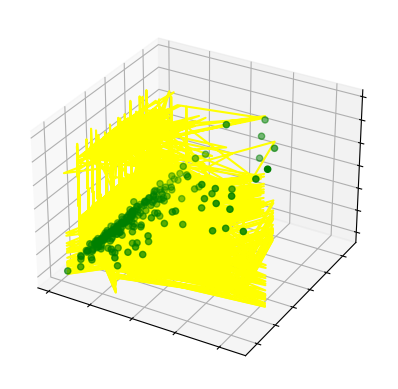

In [31]:
from mpl_toolkits.mplot3d import axes3d

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection="3d")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(
    X_test_enr_rb[:, 0], X_test_enr_rb[:, 1], y_test_enr_rb, color="green"
)

ax.plot_wireframe(
    X_test_enr_rb[:, 0],
    X_test_enr_rb[:, 1],
    y_pred_enr_rb,
    color="yellow",
    rstride=10,
    cstride=10,
)

ax.set(
    xticklabels=["Enroll"], yticklabels=["Room.Board"], zticklabels=["Accept"]
)

plt.show()

In [32]:
# Nhập code của bạn ở đây
drawPlane(
    model=model_multiple_regr_enr_rb,
    X_test=X_test_enr_rb,
    y_test=y_test_enr_rb,
    title="Test",
)

R2: 0.8764371774214047
Intercept(s):  [-1176.62848249]


<Figure size 640x480 with 0 Axes>

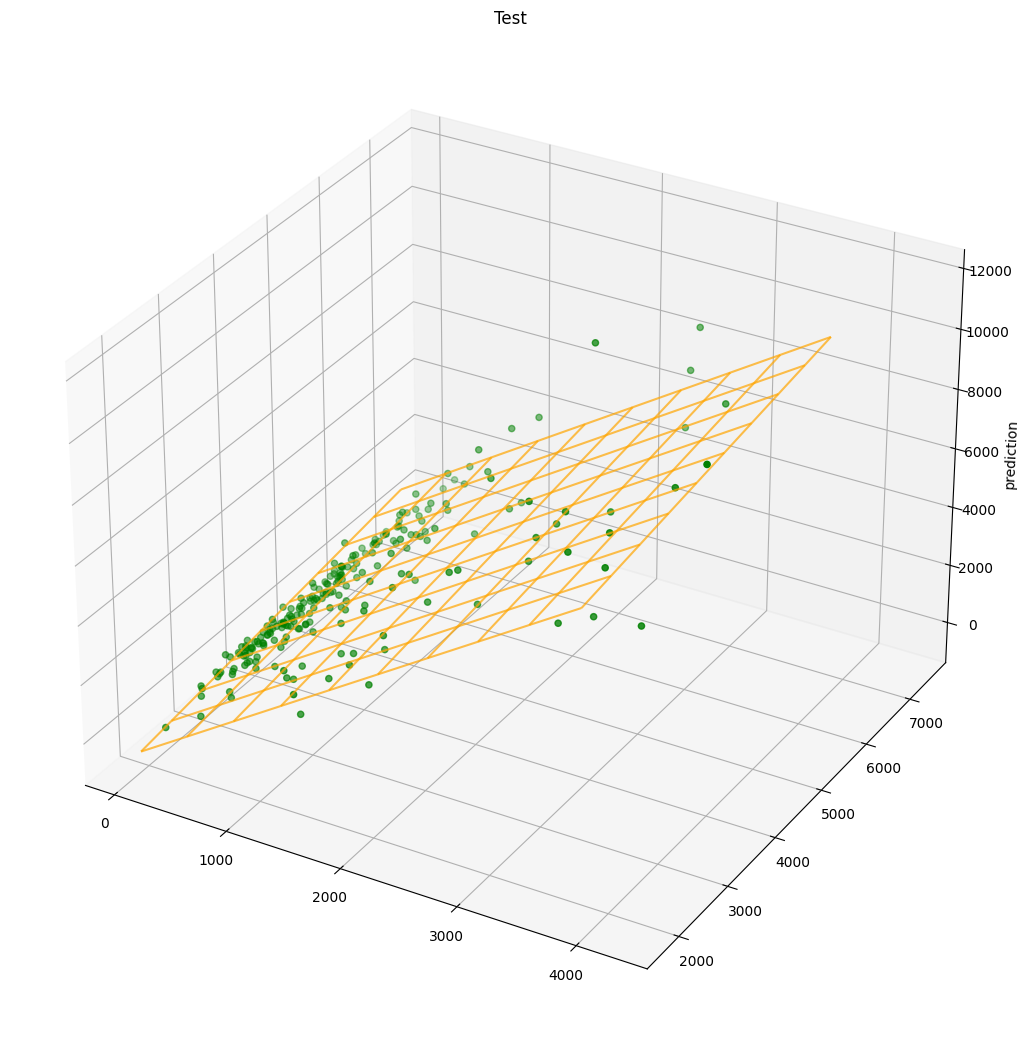

In [35]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig, auto_add_to_figure=False)
    ax.set_zlabel("prediction")
    fig.add_axes(ax)

    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:, 0]
    col2 = X_test[:, 1]

    # return X_test

    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max - x_min) / 10)
    y = np.arange(y_min, y_max, (y_max - y_min) / 10)
    x, y = np.meshgrid(x, y)

    # return x, y

    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # return z

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c="g", marker="o")
    ax.plot_wireframe(X=x, Y=y, Z=z, color="orange", alpha=0.7)
    ax.set_title(title)

    # y_pred = model.predict(X_test)
    # R2 = r2_score(y_test, y_pred)

    # print("R2: " + str(R2))
    # print("Intercept(s): ", model.intercept_)

    plt.show()


drawPlane(
    model=model_multiple_regr_enr_rb,
    X_test=X_test_enr_rb,
    y_test=y_test_enr_rb,
    title="Test",
)

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [33]:
X_train_all = np.asanyarray(X_train)
y_train_all = np.asanyarray(y_train)
X_test_all = np.asanyarray(X_test)
y_test_all = np.asanyarray(y_test)

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [34]:
feature_count = len(X_train.columns.to_list())
X_train_all = np.reshape(a=X_train_all, newshape=(-1, feature_count))
y_train_all = np.reshape(a=y_train_all, newshape=(-1, 1))
X_test_all = np.reshape(a=X_test_all, newshape=(-1, feature_count))
y_test_all = np.reshape(a=y_test_all, newshape=(-1, 1))

Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

Z-score normalization:
$$Z = \frac{X - \mu}{\sigma}$$

Where:
- $Z$ is the Z-score (standardized value).
- $X$ is the original data value.
- $\mu$ is the mean (average) of the data values.
- $\sigma$ is the standard deviation of the data values.


In [35]:
# This is a normalization process
# it used Z-score normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X=X_train_all)
X_train_all_scaled = scaler.transform(X=X_train_all)

scaler.fit(X=X_test_all)
X_test_all_scaled = scaler.transform(X=X_test_all)

Xây dựng và huấn luyện mô hình

In [36]:
model_all = LinearRegression()
model_all.fit(X=X_train_all_scaled, y=y_train_all)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [37]:
model_all.score(X=X_test_all_scaled, y=y_test_all)

0.8062763289771812

Quan sát trong số đối với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu trọng số của từng đặc trưng với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy trọng số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

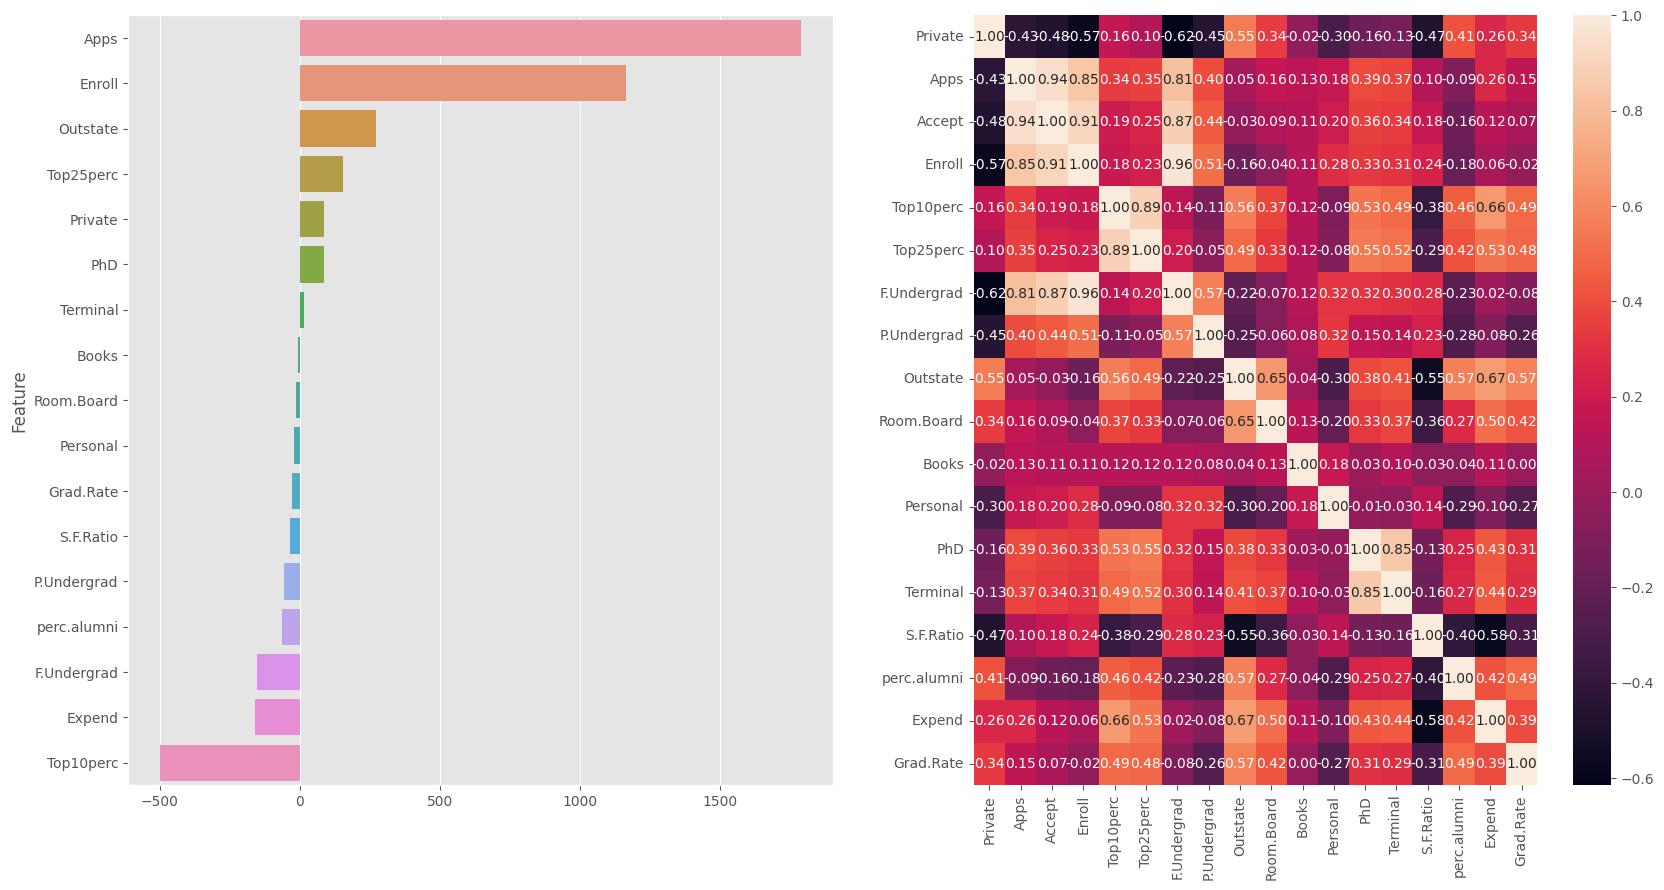

In [38]:
coef_df = (
    pd.DataFrame(
        data={
            "Feature": X_train.columns.to_list(),
            "Coefficient": np.reshape(a=model_all.coef_, newshape=(-1)),
        },
    )
    .sort_values(by="Coefficient", ascending=False)
    .set_index("Feature")
)

plt.figure(figsize=(20, 10))
# Bar plot for coefficient
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=coef_df.transpose(), orient="h")

# Bar plot for coefficient
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(data=df_corr, annot=True, fmt=".2f")

plt.show()

**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời): Apps, với coefficient lớn nhất và corrlation ~0.94

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời): Books, với coefficient ~ 0 và correlation ~ 0.11 (có thể là cả Grad.Rate vì correlation gần 0 nhất, cofficient cũng chấp nhận được ~ 0)

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


For this specific problems, we would use Ridge Regression (as a hypertuning - cross-validation method)

In [39]:
# import Ridge
from sklearn.linear_model import Ridge

# train test split the whole feature + target
X_train_ridge = np.asanyarray(X_train)
y_train_ridge = np.asanyarray(y_train)
X_test_ridge = np.asanyarray(X_test)
y_test_ridge = np.asanyarray(y_test)

## Using Pipeline to combine Standard Scaled (Normalization) and Ridge Regression

In [40]:
from sklearn.pipeline import Pipeline

pipeline_ridge = Pipeline(
    [
        ("scaler", StandardScaler()),  # Step 1: Standard Scaler
        ("ridge", Ridge()),  # Step 2: Ridge Regression
    ]
)

# Fit the pipeline to the training data
pipeline_ridge.fit(X=X_train_ridge, y=y_train_ridge)

# Predict using the pipeline
y_pred_ridge = pipeline_ridge.predict(X=X_test_ridge)

# Intercept and coefficient
coef_ridge = pipeline_ridge.named_steps["ridge"].coef_
intercept_ridge = pipeline_ridge.named_steps["ridge"].intercept_

# Measure error by score R^2
score_ridge = pipeline_ridge.score(X=X_test_ridge, y=y_test_ridge)
print("R^2 of ")
coef_df

R^2 of 


,Coefficient
Feature,
Apps,1788.195579
Enroll,1166.094588
Outstate,271.437135
Top25perc,152.959466
Private,86.338167
PhD,86.299723
Terminal,16.690016
Books,-4.996008
Room.Board,-12.106168


In [41]:
from IPython.display import Markdown as md

md(
    "Model đã pass qua requirement của đề bài với $R^2 = {:.3f}$, hãy visualize coef của các feature".format(
        score_ridge
    )
)

Model đã pass qua requirement của đề bài với $R^2 = 0.920$, hãy visualize coef của các feature

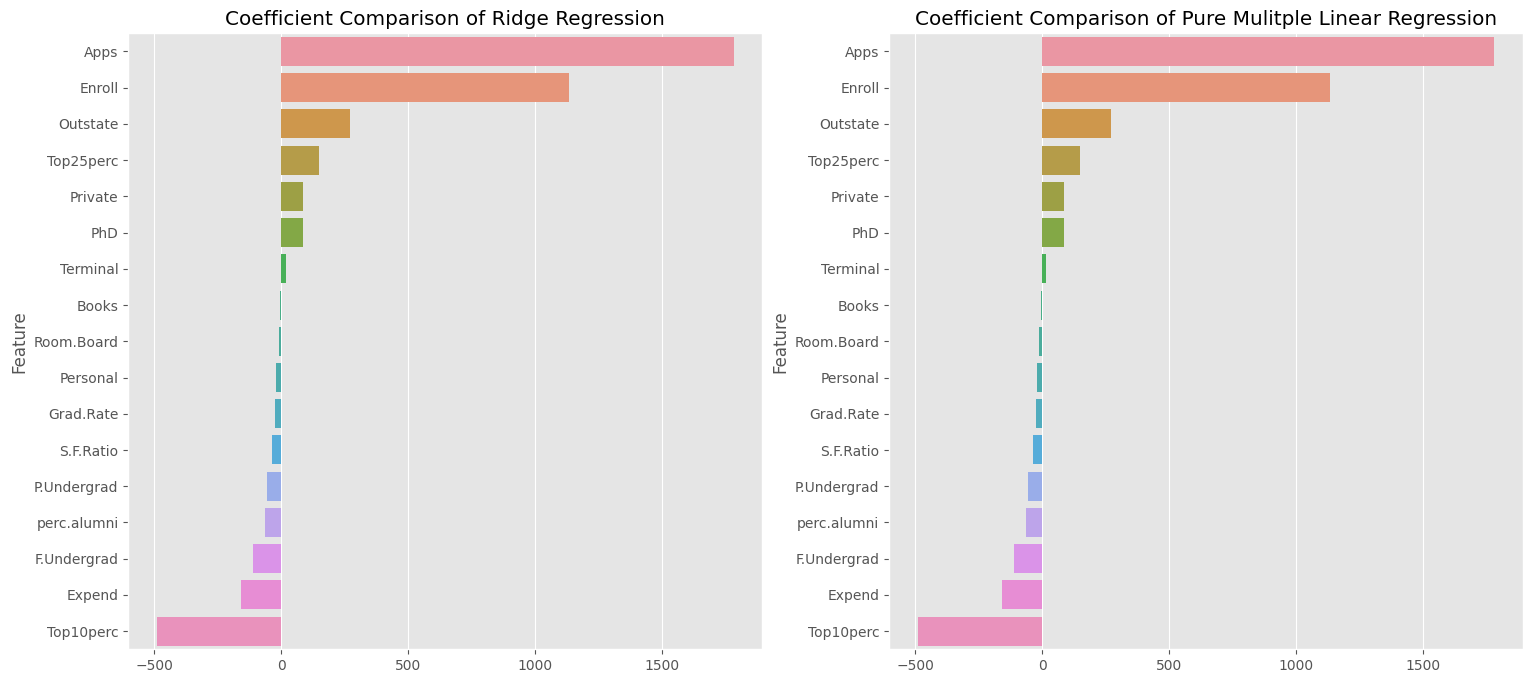

In [42]:
coef_ridge_df = pd.DataFrame(
    data={"Feature": X_train.columns.to_list(), "Coefficient": coef_ridge}
).set_index("Feature")
coef_ridge_df.sort_values(by="Coefficient", ascending=False, inplace=True)

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=coef_ridge_df.transpose(), orient="h")
plt.title("Coefficient Comparison of Ridge Regression")

plt.subplot(1, 2, 2)
sns.barplot(data=coef_ridge_df.transpose(), orient="h")
plt.title("Coefficient Comparison of Pure Mulitple Linear Regression")
plt.show()

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

Trả lời (nhấn vào đây để trả lời):
- Như plot trên, chúng ta có thể thấy sử dụng Ridge Regression có kết quả gần tương tự với câu 11, tuy nhiên có khác biệt với việc các thông số được optimize nhiều hơn
- Giải thích về `Ridge Regression...`

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

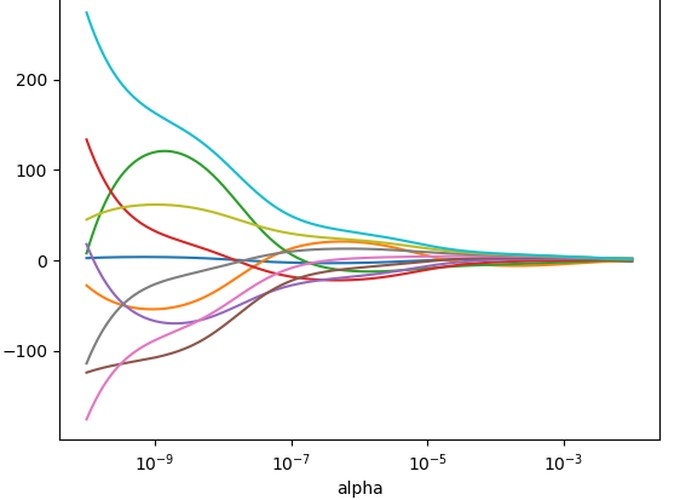

The objective function of Lasso Regression, which is minimized, is defined as:

$$ \text{Minimize} \left( \frac{1}{n} \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right) $$

Where:
- $y_i$ is the actual value for the $i$-th observation.
- $X_i$ is the feature vector for the $i$-th observation.
- $\beta$ is the vector of regression coefficients.
- $n$ is the number of observations.
- $\alpha$ is a non-negative regularization parameter.
- $p$ is the number of features.

Another note: 
* Mean squared error
$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - X_i \beta)^2$$

* Lasso Regulation Term
$$ Lasso = \alpha \sum_{j=1}^{p} |\beta_j|  $$

In order to minimize this function, we will minimize the above 2 function together, which is MSE and Lasso. MSE is similar to normal Multiple Linear Regression, thus in this context, we should only focus on Lasso. 

Minimize the `Lasso Regulatation Term` required a trial-and-error for each $\alpha$, thus making a while-loop that stop until $R^2 >=0.9 $

In [77]:
from sklearn.linear_model import Lasso
from IPython.display import clear_output

# List of alphas to try
alphas_lasso = np.logspace(-3, 3, 100)

# Initialize an array to store coefficients
coefs_lasso = []

# Initialize r^2 (score)
scores_lasso = []

# Train a Pipeline with Standard Scaler and Lasso Regression for each alpha and store the coefficients
i = 0
for alpha_lasso in alphas_lasso:
    clear_output(wait=True)
    pipeline_lasso = Pipeline(
        [
            ("scaler", StandardScaler()),  # Step 1: Normalization
            (
                "lasso",
                Lasso(alpha=alpha_lasso, max_iter=10000),
            ),  # Step 2: Lasso
        ]
    )
    pipeline_lasso.fit(X=X_train_ridge, y=y_train_ridge)
    coefs_lasso.append(pipeline_lasso.named_steps["lasso"].coef_)
    scores_lasso.append(pipeline_lasso.score(X=X_train_ridge, y=y_train_ridge))
    i += 1
    print("Complete iteration {}/{}".format(i, len(alphas_lasso)))

Complete iteration 100/100


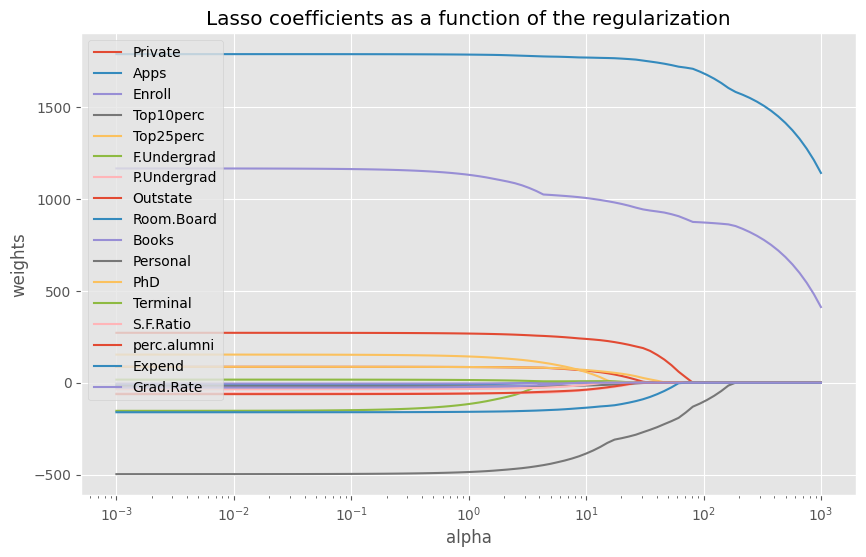

In [78]:
# Plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas_lasso, coefs_lasso)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(X_train.columns.to_list(), loc="upper left")
plt.show()
# scores_lasso
# coefs_lasso

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [79]:
# Nhập code của bạn ở đây
print(max(scores_lasso))
print(scores_lasso.index(max(scores_lasso)))

0.9606501541076906
0


Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

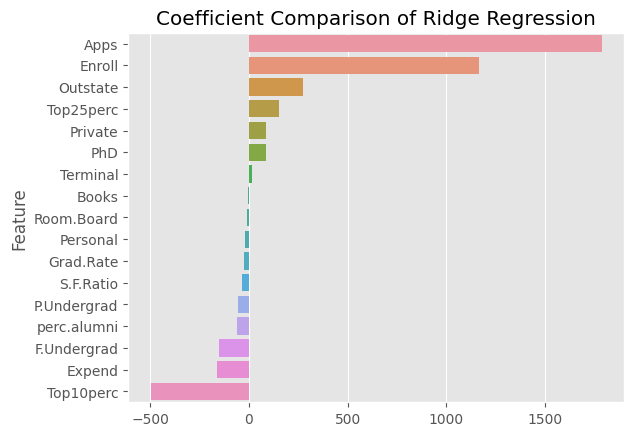

In [81]:
# Nhập code của bạn ở đây
coef_max_lasso = coefs_lasso[scores_lasso.index(max(scores_lasso))]
coef_max_lasso = (
    pd.DataFrame(
        data={
            "Feature": X_train.columns.to_list(),
            "Coefficient": coef_max_lasso,
        }
    )
    .set_index("Feature")
    .sort_values(by="Coefficient", ascending=False)
)

sns.barplot(data=coef_max_lasso.transpose(), orient="h")
plt.title("Coefficient Comparison of Ridge Regression")
plt.show()

**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

Trả lời (nhấn vào đây để trả lời):

In [106]:
from IPython.display import Markdown as md

abandon_feature = (
    coef_max_lasso.abs().sort_values(by="Coefficient", ascending=True).head(1)
)

md(
    "Bỏ đi feature {}, với $ \\beta = {:.3f} $".format(
        abandon_feature.iloc[0].name, abandon_feature.iloc[0].values[0]
    )
)

Bỏ đi feature Books, với $ \beta = 4.995 $